In [1]:
# -*- coding: utf-8 -*-
"""
Two population decision making model
References:
Wong, Kong-Fatt, and Xiao-Jing Wang.
"A recurrent network mechanism of time integration in perceptual decisions."
The Journal of neuroscience 26.4 (2006): 1314-1328.
@author: guangyu robert yang
"""

from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import math

def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))



class Model(object):
    def __init__(self, modelparams):
        # Model parameters
        self.params = modelparams.copy()

    def run(self, n_trial=1, coh=0):
        p = self.params

        # Set random seed
        if(n_trial==1):
            np.random.seed(17)
        # Number of time points
        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim = (t_plot>p['Tstim_on']) * (t_plot<p['Tstim_off'])

        mean_stim = np.ones(NT)*p['mu0']*p['Jext']/1000 # [nA]
        diff_stim = p['Jext']*p['mu0']*coh/100.*2
        Istim1_plot = (mean_stim + diff_stim/2/1000) * t_stim # [nA]
        Istim2_plot = (mean_stim - diff_stim/2/1000) * t_stim

        # Initialize S1 and S2
        S1 = 0.1*np.ones(n_trial)
        S2 = 0.1*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])
        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            # Random dot stimulus
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate

            r1  = F(Isyn1)
            r2  = F(Isyn2)

            #---- Dynamical equations -------------------------------------------

            # Mean NMDA-mediated synaptic dynamics updating
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1

        


# Q1)

We need no stimulus mu1=mu2=0 i.e mu0=0 ; run for 1000msec i.e Ttotal = 1 and no stimulation i.e Tstim_on=T_stim_off=0

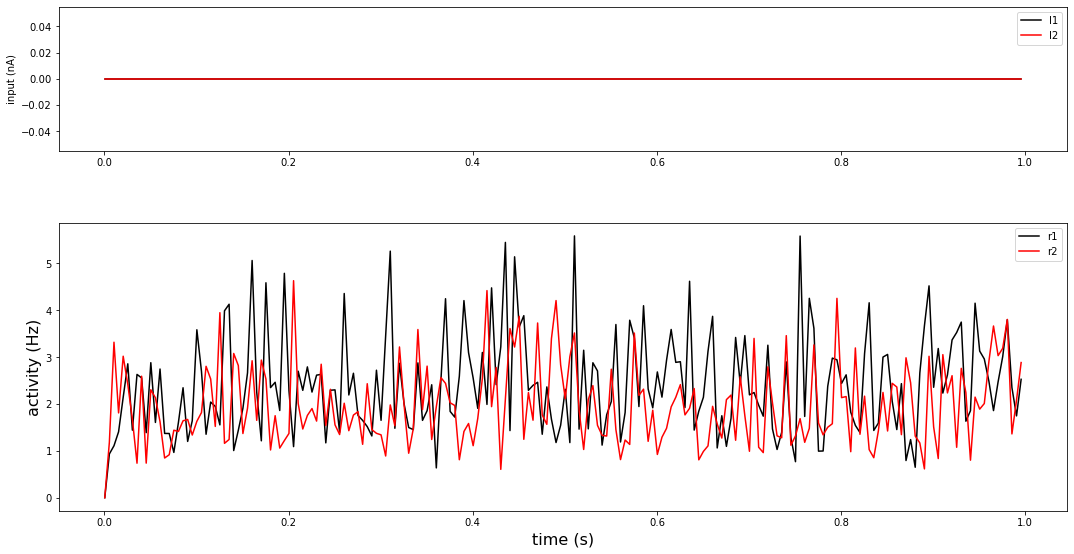

In [2]:
modelparams = dict(
    gE          = 0.2609,
    gI          = -0.0497, # cross-inhibition strength [nA]
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [sec]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu0         = 35, # Stimulus firing rate [Hz]
    Jext        = 0.52, # Stimulus input strength [pA/Hz]
    Ttotal      = 1., # Total duration of simulation [s]
    Tstim_on    = 0, # Time of stimulus onset
    Tstim_off   = 0, # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)



model = Model(modelparams)
model.run(coh=0, n_trial=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.2, 0.7, 0.7, 0.2])
plt.plot(model.t, model.I1, 'black',label="I1")
plt.plot(model.t, model.I2, 'red',label="I2")
plt.legend()
plt.ylabel('input (nA)')

ax = fig.add_axes([0.2, 0.2, 0.7, 0.4])
plt.plot(model.t, model.r1,'black',label="r1")
plt.plot(model.t, model.r2,'red',label="r2")
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('activity (Hz)',fontsize=16)
plt.legend()
plt.show()

# We observe a resting state of a few Hz.

# Stimulus for $\mu_1=35Hz$   for a brief period of time (300 msec), followed by a delay ‘memory period’ (for 3 sec).

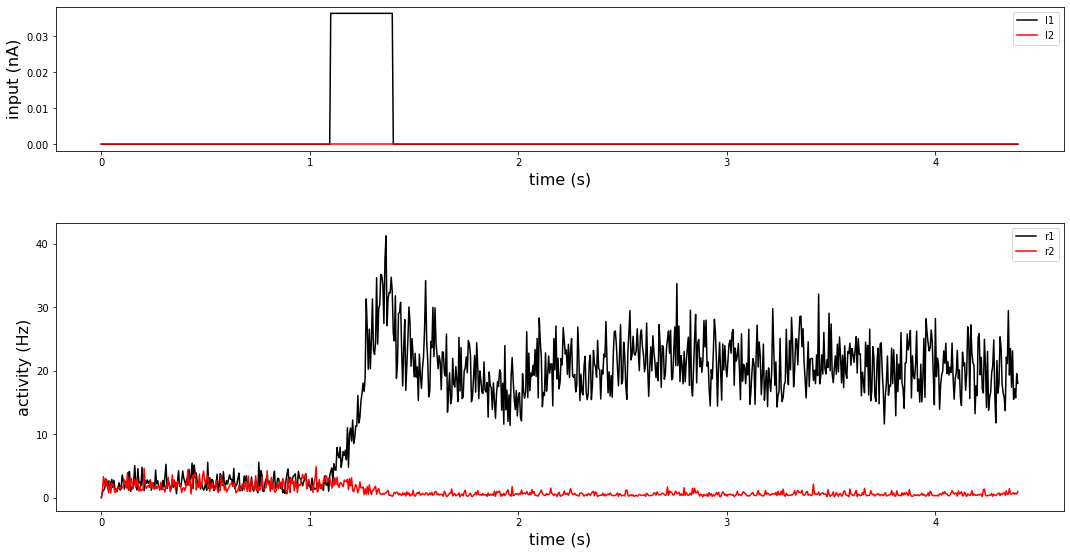

In [212]:
modelparams = dict(
    gE          = 0.2609,
    gI          = -0.0497, # cross-inhibition strength [nA]
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [sec]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu0         = 35, # Stimulus firing rate [Hz]
    Jext        = 0.52, # Stimulus input strength [pA/Hz]
    Ttotal      = 4.4, # Total duration of simulation [s]
    Tstim_on    = 1.1, # Time of stimulus onset
    Tstim_off   = 1.4, # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)


model = Model(modelparams)
model.run(coh=100, n_trial=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.2, 0.7, 0.7, 0.2])
plt.plot(model.t, model.I1, 'black',label="I1")
plt.plot(model.t, model.I2, 'red',label="I2")
plt.legend()
plt.ylabel('input (nA)',fontsize=16)
plt.xlabel('time (s)',fontsize=16)

ax = fig.add_axes([0.2, 0.2, 0.7, 0.4])
plt.plot(model.t, model.r1,'black',label="r1")
plt.plot(model.t, model.r2,'red',label="r2")
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('activity (Hz)',fontsize=16)
plt.legend()
plt.show()

# We observe a memory state with r1 ≃ 25 Hz, r2 ≃ 0 Hz.

# Stimulus for $\mu_2=35Hz$   for a brief period of time (300 msec), followed by a delay ‘memory period’ (for 3 sec).

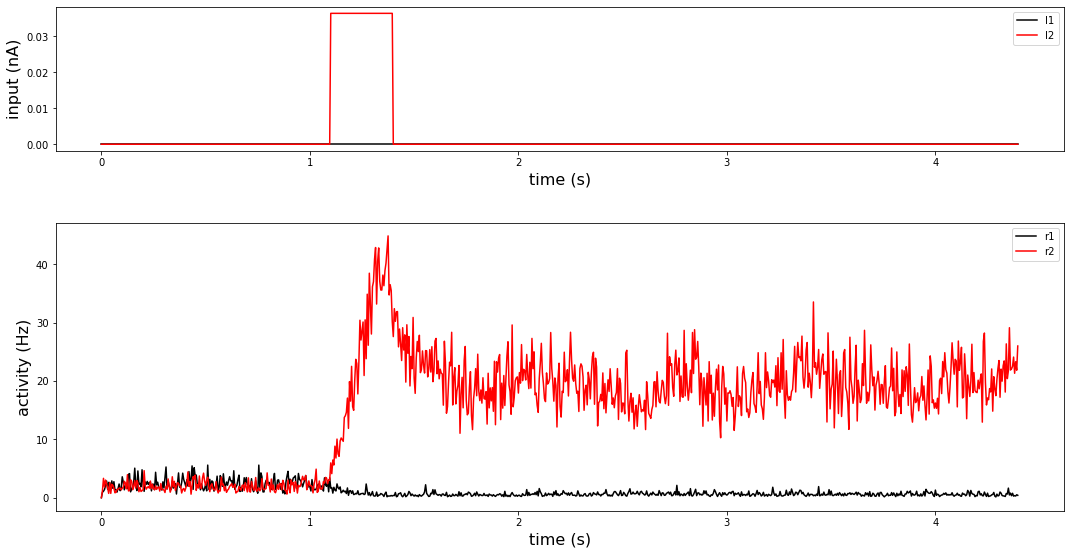

In [213]:
modelparams = dict(
    gE          = 0.2609,
    gI          = -0.0497, # cross-inhibition strength [nA]
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [sec]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu0         = 35, # Stimulus firing rate [Hz]
    Jext        = 0.52, # Stimulus input strength [pA/Hz]
    Ttotal      = 4.4, # Total duration of simulation [s]
    Tstim_on    = 1.1, # Time of stimulus onset
    Tstim_off   = 1.4, # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)


model = Model(modelparams)
model.run(coh=-100, n_trial=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.2, 0.7, 0.7, 0.2])
plt.plot(model.t, model.I1, 'black',label="I1")
plt.plot(model.t, model.I2, 'red',label="I2")
plt.legend()
plt.ylabel('input (nA)',fontsize=16)
plt.xlabel('time (s)',fontsize=16)

ax = fig.add_axes([0.2, 0.2, 0.7, 0.4])
plt.plot(model.t, model.r1,'black',label="r1")
plt.plot(model.t, model.r2,'red',label="r2")
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('activity (Hz)',fontsize=16)
plt.legend()
plt.show()

# We observe another memory state with r1 ≃ 0 Hz, r2 ≃ 25 Hz

# Create a class model that can handle multiple inputs

In [214]:



def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))



class Model_multiple_inputs(object):
    def __init__(self, modelparams):
        # Model parameters
        self.params = modelparams.copy()

    def run(self, n_trial=1, coh=0, coh1 =0):
        p = self.params

        # Set random seed
        np.random.seed(17)

        # Number of time points
        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim = (t_plot>p['Tstim_on']) * (t_plot<p['Tstim_off'])
        
        t_stim1 = (t_plot>p['Tstim_on1']) * (t_plot<p['Tstim_off1'])   #### new

        mean_stim = np.ones(NT)*p['mu0']*p['Jext']/1000 # [nA]
        diff_stim = p['Jext']*p['mu0']*coh/100.*2
        diff_stim1 = p['Jext']*p['mu0']*coh1/100.*2    ### new
        Istim1_plot = (mean_stim + diff_stim/2/1000) * t_stim + (mean_stim + diff_stim1/2/1000) * t_stim1  # [nA]
        Istim2_plot = (mean_stim - diff_stim/2/1000) * t_stim + (mean_stim - diff_stim1/2/1000) * t_stim1
        
        
        


        # Initialize S1 and S2
        S1 = 0.1*np.ones(n_trial)
        S2 = 0.1*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])
        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)
        self.S1 = 0.1*np.ones(N_record)
        self.S2 = 0.1*np.ones(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            # Random dot stimulus
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate

            r1  = F(Isyn1)
            r2  = F(Isyn2)

            #---- Dynamical equations -------------------------------------------

            # Mean NMDA-mediated synaptic dynamics updating
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                self.S1[i_record] = S1
                self.S2[i_record] = S2
                i_record += 1

        


# In addition to the previous stimulus I added another one starting at 4.5 seconds and ending at 5.2 seconds  with coh1=80. To do so I modified the code to handle multiple inputs (Model_multiple_inputs).
# I chose coherence of 80 so that this time I1 is strong and can counterbalance previous strength of I2.

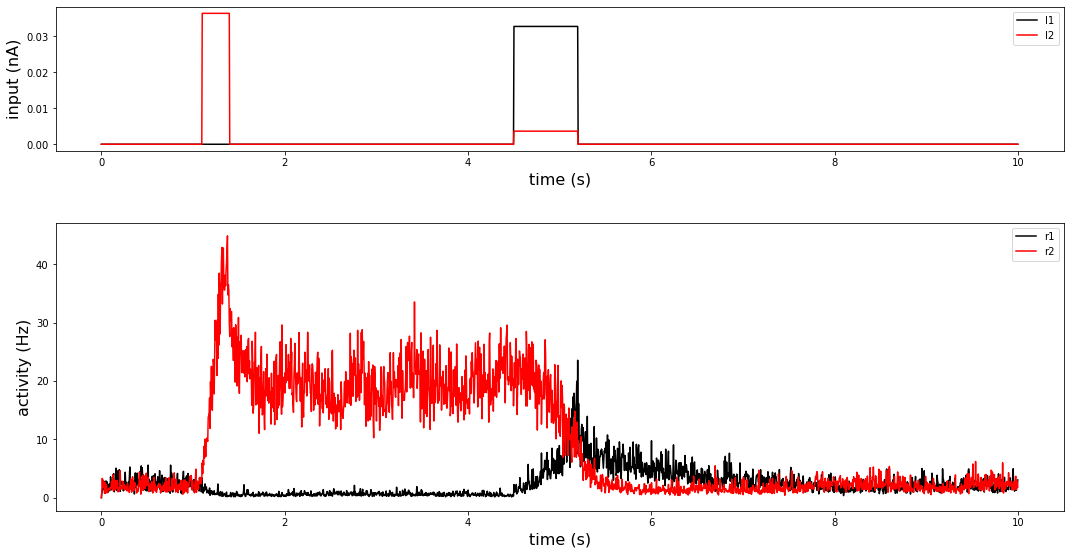

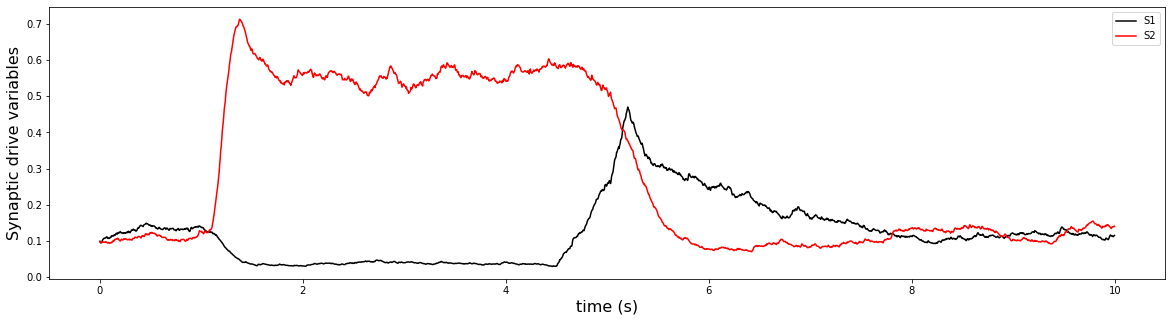

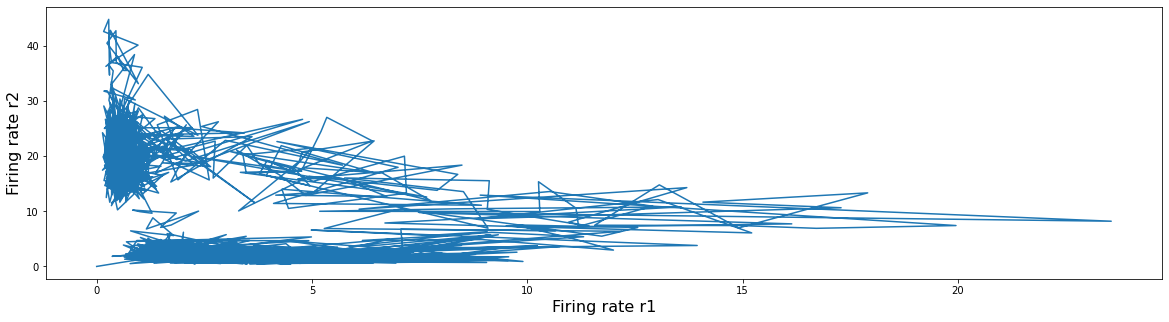

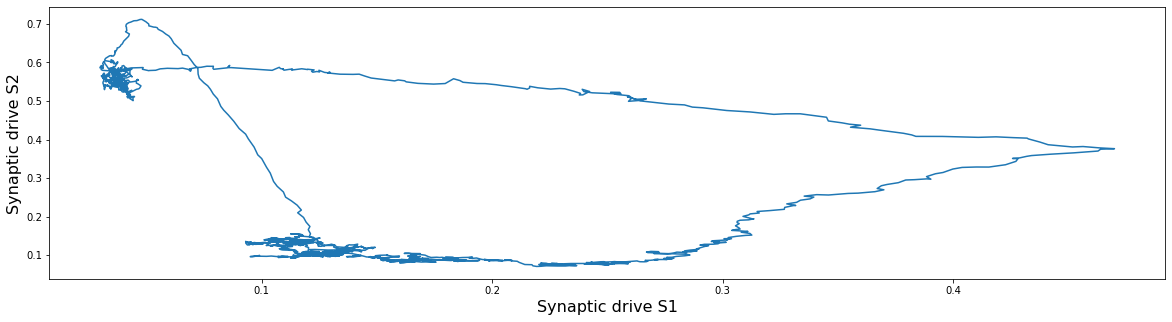

In [215]:
modelparams = dict(
    gE          = 0.2609,
    gI          = -0.0497, # cross-inhibition strength [nA]
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [sec]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu0         = 35, # Stimulus firing rate [Hz]
    Jext        = 0.52, # Stimulus input strength [pA/Hz]
    Ttotal      = 10, # Total duration of simulation [s]
    Tstim_on    = 1.1, # Time of stimulus onset
    Tstim_off   = 1.4, # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.,
    Tstim_on1    = 4.5, # Time of stimulus onset
    Tstim_off1   = 5.2 # Time of stimulus offset
)






model = Model_multiple_inputs(modelparams)
model.run(coh=-100,coh1=80, n_trial=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.2, 0.7, 0.7, 0.2])
plt.plot(model.t, model.I1, 'black',label="I1")
plt.plot(model.t, model.I2, 'red',label="I2")
plt.legend()
plt.ylabel('input (nA)',fontsize=16)
plt.xlabel('time (s)',fontsize=16)

ax = fig.add_axes([0.2, 0.2, 0.7, 0.4])
plt.plot(model.t, model.r1,'black',label="r1")
plt.plot(model.t, model.r2,'red',label="r2")
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('activity (Hz)',fontsize=16)
plt.legend()
plt.show()

plt.plot(model.t,model.S1,'black',label="S1")
plt.plot(model.t,model.S2,'red',label="S2")
plt.legend()
plt.ylabel('Synaptic drive variables',fontsize=16)
plt.xlabel('time (s)',fontsize=16)
plt.show()


plt.plot(model.r1,model.r2)
plt.ylabel('Firing rate r2',fontsize=16)
plt.xlabel('Firing rate r1',fontsize=16)
plt.show()
plt.plot(model.S1,model.S2)
plt.ylabel('Synaptic drive S2',fontsize=16)
plt.xlabel('Synaptic drive S1',fontsize=16)
plt.show()

# Q2)

In [130]:
modelparams = dict(
    gE          = 0.2609,
    gI          = -0.0497, # cross-inhibition strength [nA]
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [sec]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu0         = 30, # Stimulus firing rate [Hz]
    Jext        = 0.52, # Stimulus input strength [pA/Hz]
    Ttotal      = 3, # Total duration of simulation [s]
    Tstim_on    = 0.5, # Time of stimulus onset
    Tstim_off   = 1.5, # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

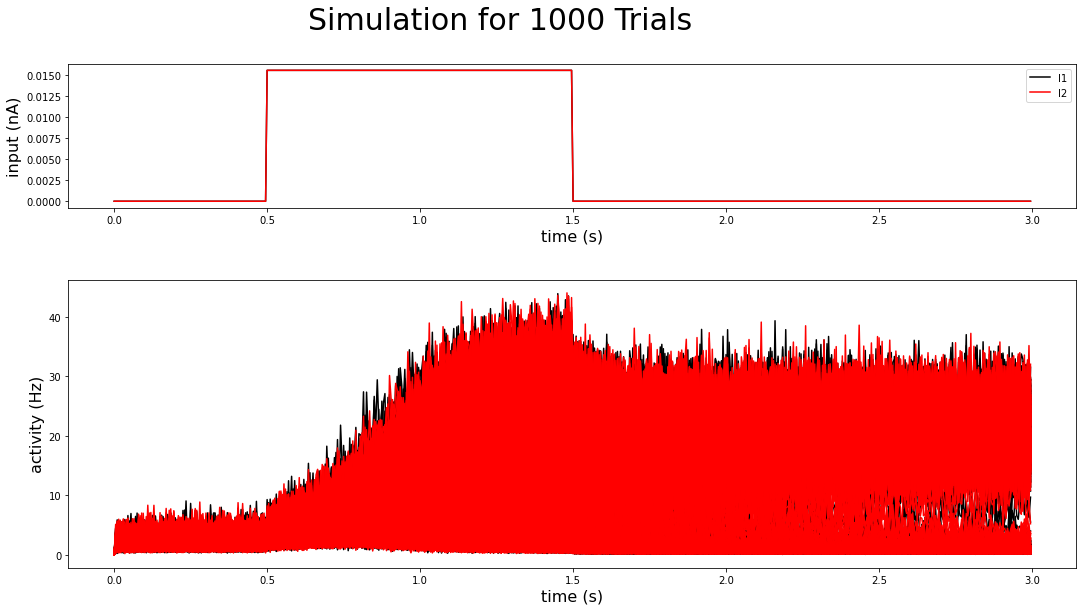

In [131]:

model = Model(modelparams)
N_trial=1000
model.run(coh=0, n_trial=N_trial)

fig = plt.figure(figsize=(20,10))
fig.suptitle("Simulation for 1000 Trials",fontsize=30)
ax = fig.add_axes([0.2, 0.7, 0.7, 0.2])
plt.plot(model.t, model.I1, 'black',label="I1")
plt.plot(model.t, model.I2, 'red',label="I2")
plt.legend()
plt.ylabel('input (nA)',fontsize=16)
plt.xlabel('time (s)',fontsize=16)

ax = fig.add_axes([0.2, 0.2, 0.7, 0.4])
plt.plot(model.t, model.r1,'black',label="r1")
plt.plot(model.t, model.r2,'red',label="r2")
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('activity (Hz)',fontsize=16)
plt.show()

# Let's count decision outcomes by comparing for each trial the values of r1 and r2 :

In [276]:
print("Decision outcome percentage :")
100*([model.r1[-1][t]> model.r2[-1][t] for t in range(N_trial)].count(True)/N_trial)

Decision outcome percentage :


50.3

# As expected, if we run enough random number of trials we should see 50-50 decision outcome in this particular setting

# Q3)

In [81]:
coherences= [3.2,6.4,12.8,25.6,51.2,85,100]
decision1_percentage =[]
for c in coherences :
    modelparams = dict(
    gE          = 0.2609,
    gI          = -0.0497, # cross-inhibition strength [nA]
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [sec]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu0         = 30, # Stimulus firing rate [Hz]
    Jext        = 0.52, # Stimulus input strength [pA/Hz]
    Ttotal      = 3, # Total duration of simulation [s]
    Tstim_on    = 0.5, # Time of stimulus onset
    Tstim_off   = 1.5, # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
    )
    model = Model(modelparams)
    N_trial=1000
    model.run(coh=c, n_trial=N_trial)
    decision1_percentage.append(100*([model.r1[-1][t]> model.r2[-1][t] for t in range(N_trial)].count(True)/N_trial))

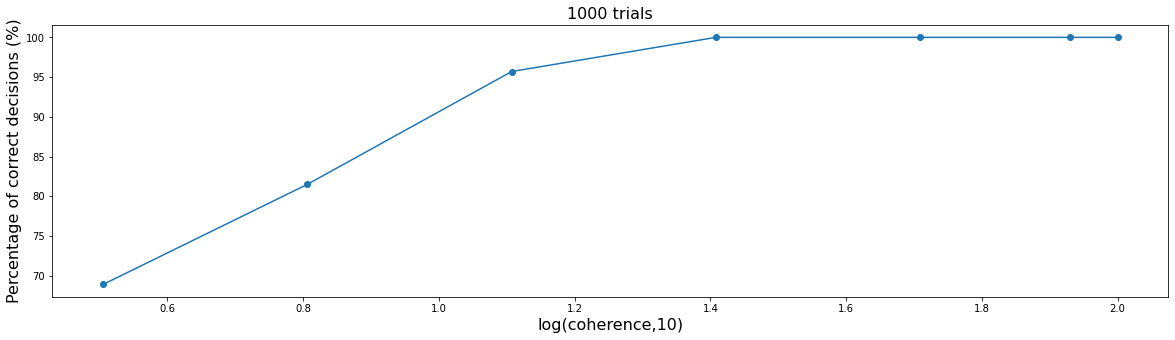

In [84]:


plt.plot(np.log10(coherences),decision1_percentage,marker="o")
plt.xlabel('log(coherence,10)',fontsize=16)
plt.ylabel('Percentage of correct decisions (%)',fontsize=16)
plt.title("1000 trials",fontsize=16)
plt.show()

# As expected increasing the coherence will decrease the uncertainty and therefore increase percentage of correct decisions.

# Q4)

# (a) Plot firing time (x-axis) vs firing rate (y-axis) for the two populations

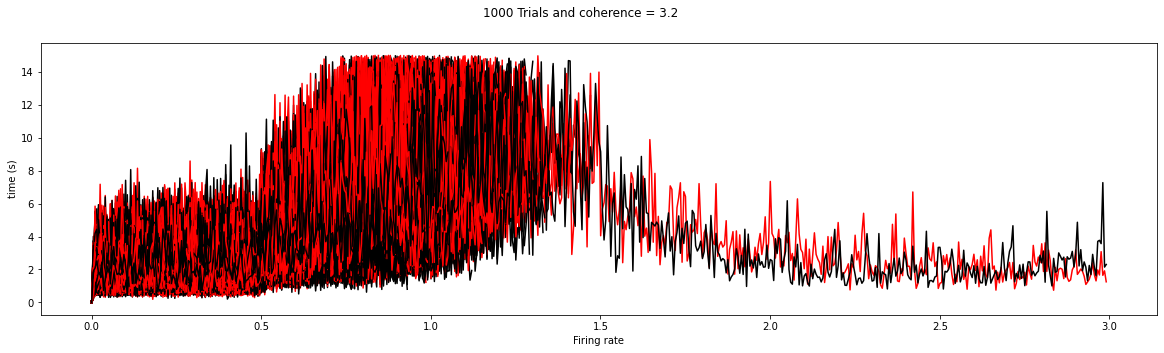

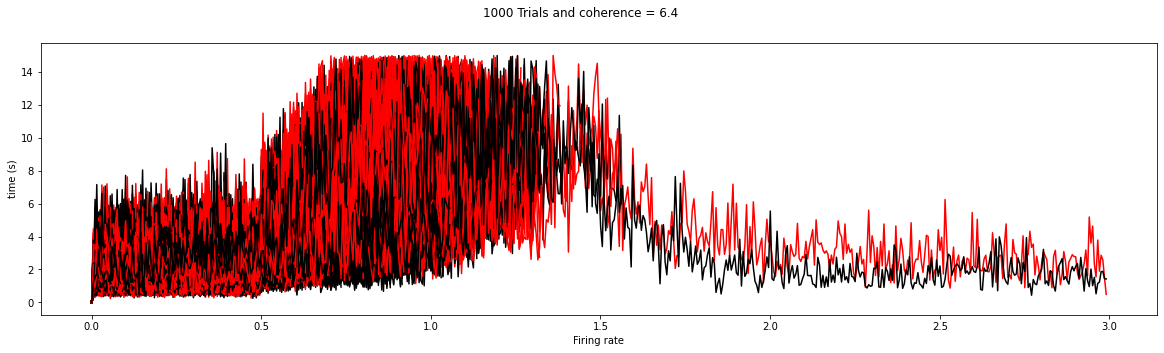

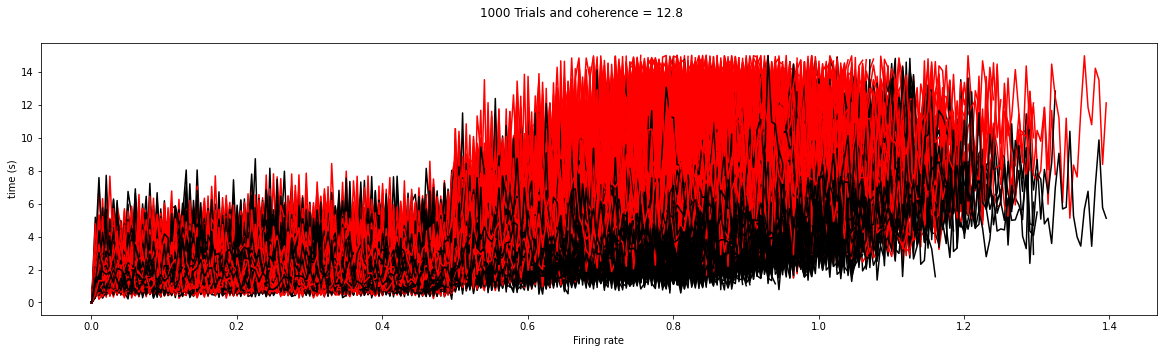

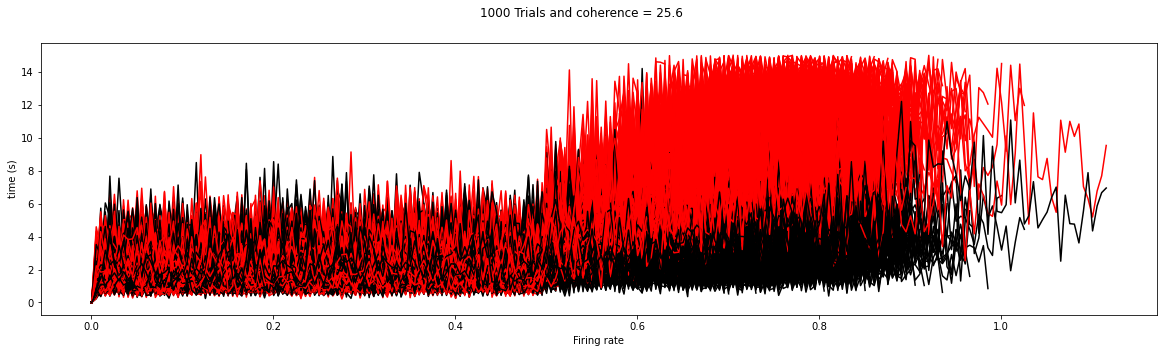

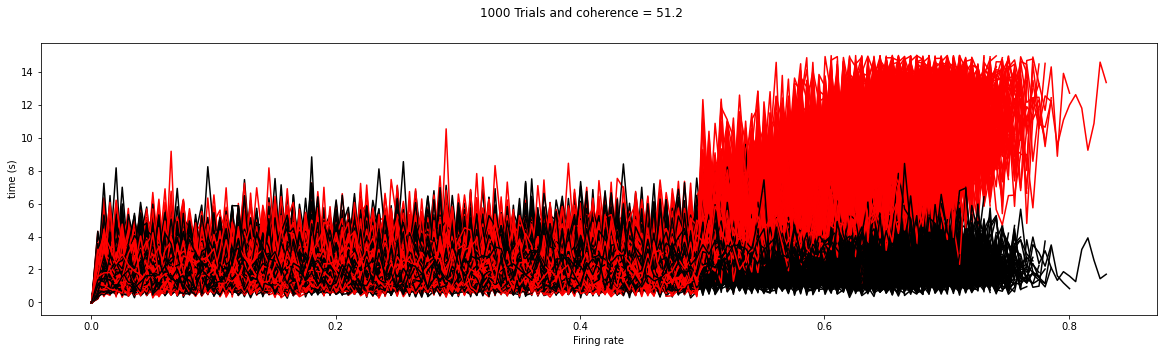

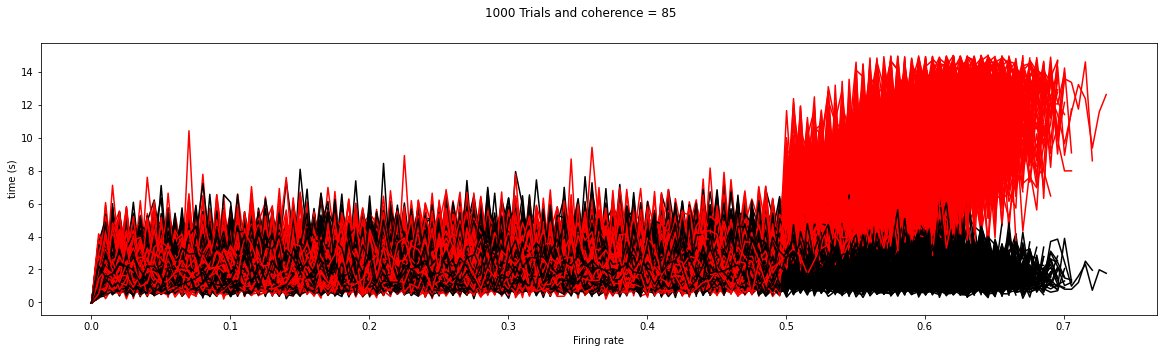

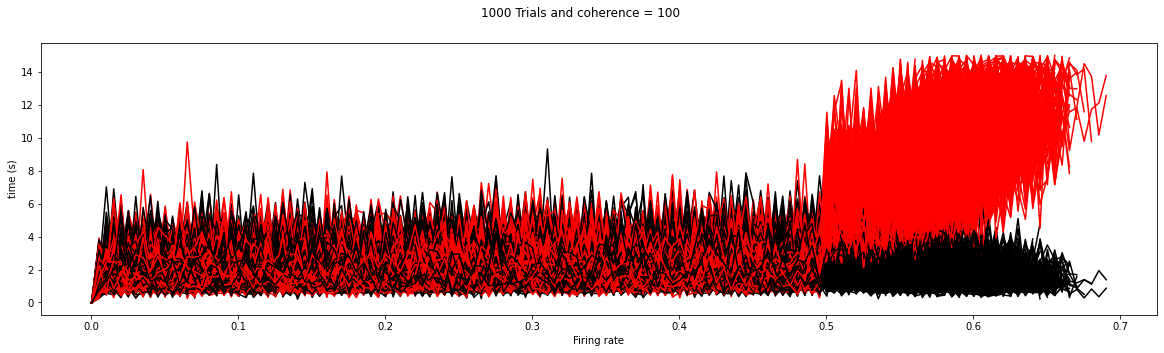

In [186]:
coherences= [3.2,6.4,12.8,25.6,51.2,85,100]
decision1_percentage_threshold =[]
decision1_percentage_no_threshold =[]
Ttotal = 3
reaction_time = []
r1_pops = []
r2_pops =[]
for c in coherences :
    modelparams = dict(
    gE          = 0.2609,
    gI          = -0.0497, # cross-inhibition strength [nA]
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [sec]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu0         = 30, # Stimulus firing rate [Hz]
    Jext        = 0.52, # Stimulus input strength [pA/Hz]
    Ttotal      = Ttotal, # Total duration of simulation [s]
    Tstim_on    = 0.5, # Time of stimulus onset
    Tstim_off   = 1.5, # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
    )
    model = Model(modelparams)
    N_trial=1000
    threshold = 15
    model.run(coh=c, n_trial=N_trial)
    list1=[np.where((model.r1.T)[t]>threshold)[0][0] if len(np.where((model.r1.T)[t]>threshold)[0])>0 else Ttotal*200-1 for t in range(N_trial)]
    list2=[np.where((model.r2.T)[t]>threshold)[0][0] if len(np.where((model.r2.T)[t]>threshold)[0])>0 else Ttotal*200-1 for t in range(N_trial)]
    val_min = [min(i) for i in zip(list1,list2)]
    r1_pops.append(model.r1)
    r2_pops.append(model.r2)
    reaction_time.append(val_min)
    decision1_percentage_threshold.append(100*([model.r1[val_min[t]][t]> model.r2[val_min[t]][t] for t in range(N_trial)].count(True)/N_trial))
    decision1_percentage_no_threshold.append(100*([model.r1[-1][t]> model.r2[-1][t] for t in range(N_trial)].count(True)/N_trial))
    count=0
    for v in val_min:
        plt.plot(model.t[0:v],model.r1.T[count][0:v],'red',label="r1")
        plt.plot(model.t[0:v],model.r2.T[count][0:v],'black',label="r2")
        plt.xlabel("Firing rate")
        plt.ylabel("time (s)")
        plt.suptitle("1000 Trials and coherence = "+str(c))
        count+=1
    plt.show()

# (b)

In [85]:
coherences= [3.2,6.4,12.8,25.6,51.2,85,100]
decision1_percentage_threshold =[]
decision1_percentage_no_threshold =[]
Ttotal = 3
reaction_time = []
for c in coherences :
    modelparams = dict(
    gE          = 0.2609,
    gI          = -0.0497, # cross-inhibition strength [nA]
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [sec]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu0         = 30, # Stimulus firing rate [Hz]
    Jext        = 0.52, # Stimulus input strength [pA/Hz]
    Ttotal      = Ttotal, # Total duration of simulation [s]
    Tstim_on    = 0.5, # Time of stimulus onset
    Tstim_off   = 1.5, # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
    )
    model = Model(modelparams)
    N_trial=1000
    threshold = 15
    model.run(coh=c, n_trial=N_trial)
    list1=[np.where((model.r1.T)[t]>threshold)[0][0] if len(np.where((model.r1.T)[t]>threshold)[0])>0 else Ttotal*200-1 for t in range(N_trial)]
    list2=[np.where((model.r2.T)[t]>threshold)[0][0] if len(np.where((model.r2.T)[t]>threshold)[0])>0 else Ttotal*200-1 for t in range(N_trial)]
    val_min = [min(i) for i in zip(list1,list2)]
    reaction_time.append(val_min)
    decision1_percentage_threshold.append(100*([model.r1[val_min[t]][t]> model.r2[val_min[t]][t] for t in range(N_trial)].count(True)/N_trial))
    decision1_percentage_no_threshold.append(100*([model.r1[-1][t]> model.r2[-1][t] for t in range(N_trial)].count(True)/N_trial))    

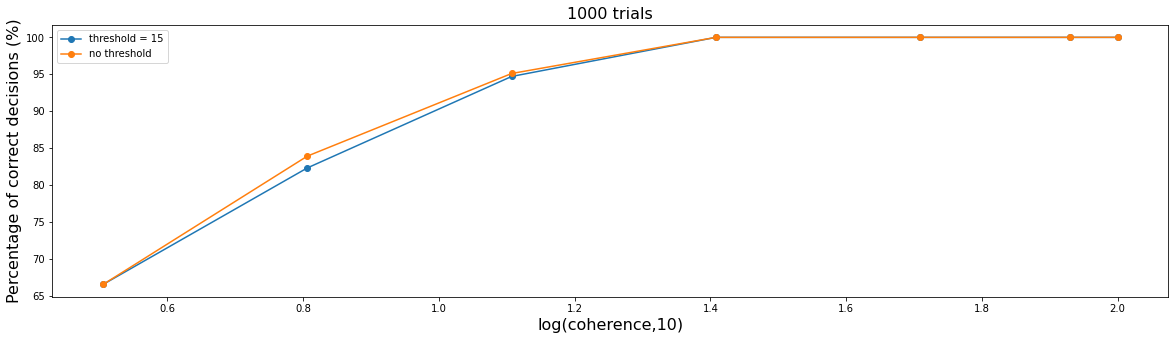

In [86]:


plt.plot(np.log10(coherences),decision1_percentage_threshold,marker="o",label="threshold = 15")
plt.plot(np.log10(coherences),decision1_percentage_no_threshold,marker="o",label="no threshold")
plt.xlabel('log(coherence,10)',fontsize=16)
plt.ylabel('Percentage of correct decisions (%)',fontsize=16)
plt.title("1000 trials",fontsize=16)
plt.legend()
plt.show()

# (c)

In [87]:
import statistics
stds = []
means = []
for sim in range(len(coherences)):
    stds.append(statistics.stdev(reaction_time[sim]))
    means.append(statistics.mean(reaction_time[sim]))
    

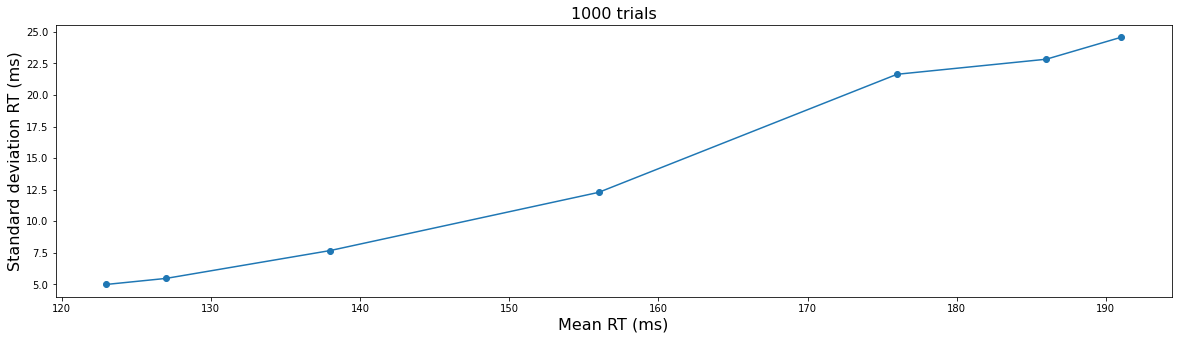

In [88]:
plt.plot(means,stds,marker="o")
plt.xlabel('Mean RT (ms)',fontsize=16)
plt.ylabel('Standard deviation RT (ms)',fontsize=16)
plt.title("1000 trials",fontsize=16)
plt.show()

# As shown in class , it follows Weber's Law and the RT standard deviation is proportional to its mean as it  has been proved theoretically even before experiments !

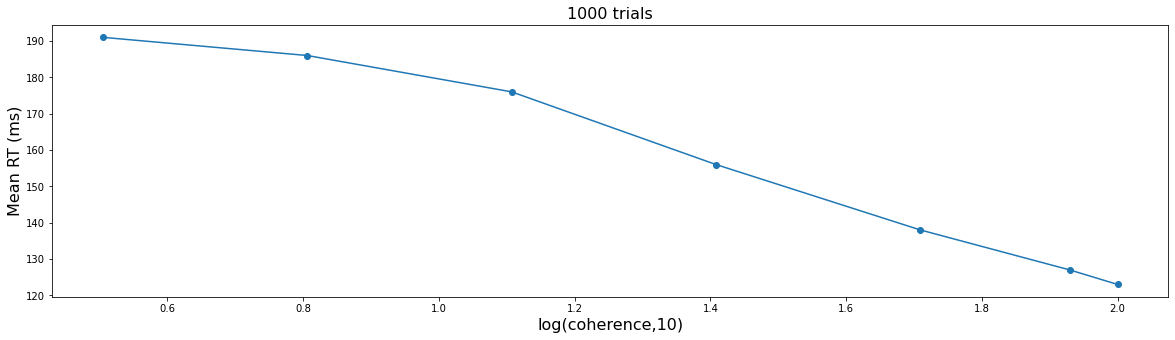

In [89]:
plt.plot(np.log10(coherences),means,marker="o")
plt.xlabel('log(coherence,10)',fontsize=16)
plt.ylabel('Mean RT (ms)',fontsize=16)
plt.title("1000 trials",fontsize=16)
plt.show()

# As shown in class, reaction time decreases with coherence

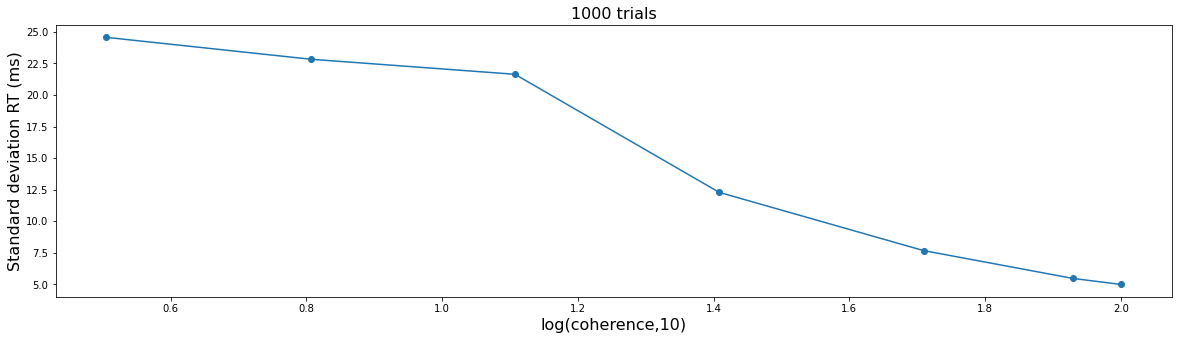

In [90]:
plt.plot(np.log10(coherences),stds,marker="o")
plt.xlabel('log(coherence,10)',fontsize=16)
plt.ylabel('Standard deviation RT (ms)',fontsize=16)
plt.title("1000 trials",fontsize=16)
plt.show()

# Q5)

# (1) Stimulus presentation and decision performance

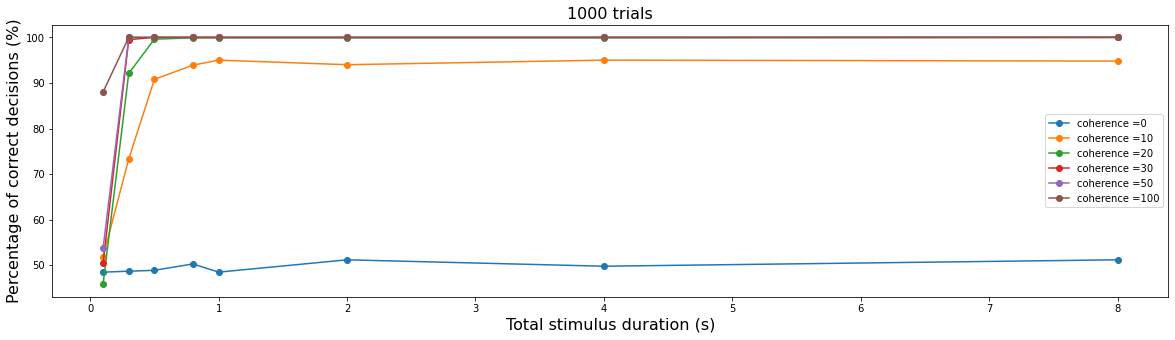

In [91]:
Tstim_on    = 0.5
Total_stim = [0.1,0.3,0.5,0.8,1,2,4,8]
coherences= [0,10,20,30,50,100]
for c in coherences:
    decision_percentage = []
    for t in [0.1,0.3,0.5,0.8,1,2,4,8]:
        modelparams = dict(
            gE          = 0.2609,
            gI          = -0.0497, # cross-inhibition strength [nA]
            I0          = 0.3255, # background current [nA]
            tauS        = 0.1, # Synaptic time constant [sec]
            gamma       = 0.641, # Saturation factor for gating variable
            tau0        = 0.002, # Noise time constant [sec]
            sigma       = 0.02, # Noise magnitude [nA]
            mu0         = 35, # Stimulus firing rate [Hz]
            Jext        = 0.52, # Stimulus input strength [pA/Hz]
            Ttotal      =10., # Total duration of simulation [s]
            Tstim_on    = Tstim_on, # Time of stimulus onset
            Tstim_off   = Tstim_on + t, # Time of stimulus offset
            dt          = 0.5/1000, # Simulation time step
            record_dt   = 5/1000.
        )



        model = Model(modelparams)

        N_trial=1000
        model.run(coh=c, n_trial=N_trial)
        decision_percentage.append(100*([model.r1[-1][t]> model.r2[-1][t] for t in range(N_trial)].count(True)/N_trial))
    plt.plot(Total_stim,decision_percentage,label='coherence ='+str(c),marker='o')
plt.xlabel('Total stimulus duration (s)',fontsize=16)
plt.ylabel('Percentage of correct decisions (%)',fontsize=16)
plt.legend()
plt.title("1000 trials",fontsize=16)
plt.show()

# As expected, the higher the stimulus duration, the better the performance. I also plotted for different coherences to check the effect on the stimulus duration and we can see that we can reach same performances with lower stimulus duration if coherence is high.
# For very short t , we can see that it is a 50-50 decision outcome and this holds no mattee the chosen coherence. I think this makes sense because the time is too short to actually capture the stimulus

# (2) Parameter dependences noise

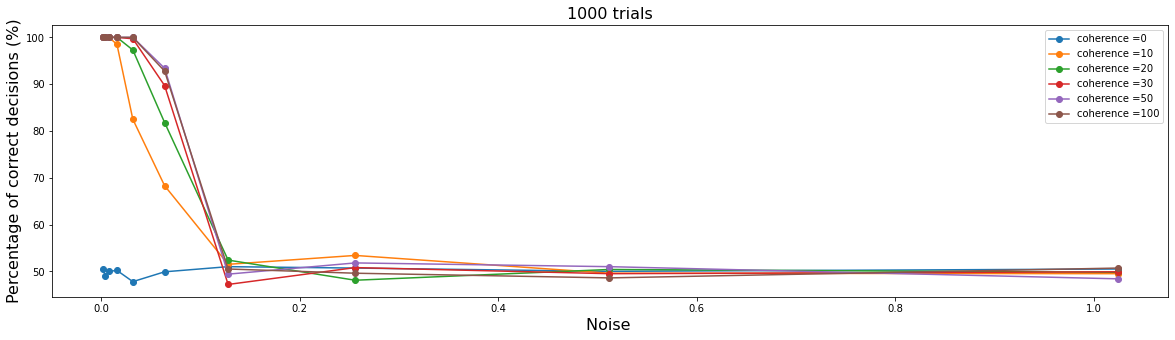

In [92]:

noises = [0.002*2**i for i in range(10)]
coherences= [0,10,20,30,50,100]
for c in coherences:
    decision_percentage = []
    for noise in noises:
        modelparams = dict(
            gE          = 0.2609,
            gI          = -0.0497, # cross-inhibition strength [nA]
            I0          = 0.3255, # background current [nA]
            tauS        = 0.1, # Synaptic time constant [sec]
            gamma       = 0.641, # Saturation factor for gating variable
            tau0        = 0.002, # Noise time constant [sec]
            sigma       = noise, # Noise magnitude [nA]
            mu0         = 35, # Stimulus firing rate [Hz]
            Jext        = 0.52, # Stimulus input strength [pA/Hz]
            Ttotal      =10., # Total duration of simulation [s]
            Tstim_on    = 0.5, # Time of stimulus onset
            Tstim_off   = 2, # Time of stimulus offset
            dt          = 0.5/1000, # Simulation time step
            record_dt   = 5/1000.
        )



        model = Model(modelparams)

        N_trial=1000
        model.run(coh=c, n_trial=N_trial)
        decision_percentage.append(100*([model.r1[-1][t]> model.r2[-1][t] for t in range(N_trial)].count(True)/N_trial))
    plt.plot(noises,decision_percentage,label='coherence ='+str(c),marker='o')
plt.xlabel('Noise ',fontsize=16)
plt.ylabel('Percentage of correct decisions (%)',fontsize=16)
plt.legend()
plt.title("1000 trials",fontsize=16)
plt.show()